## Results Summary

This notebook will focus on comparing the performance of models in 04_model_training.ipynb using:
- Confusion matrix
- Classificiation report

In [21]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [22]:
# Load results
with open("../data/results/model_results.pkl", "rb") as f:
    results = pickle.load(f)

confusion_matrices = results["confusion_matrices"]
auc_scores = results["auc_scores"]
classification_reports = results["classification_reports"]
pred_proba = results["pred_proba"]

In [23]:
# Iterate through the models and combine the macro precision, recall, f1-score, and ROC AUC into a single DataFrame
results_comparison = {}

for model_name in classification_reports.keys():
    classification_report = classification_reports[model_name]
    auc_score = auc_scores[model_name]
    
    results_comparison[model_name] = {
        "Macro Precision" : classification_report["macro avg"]["precision"],
        "Macro Recall" : classification_report["macro avg"]["recall"],
        "Macro F1" : classification_report["macro avg"]["f1-score"],
        "ROC AUC" : auc_scores[model_name]
    }
    
results_comparison_df = pd.DataFrame.from_dict(results_comparison, orient="index")
results_comparison_df = results_comparison_df.round(4).sort_values("ROC AUC", ascending=False)

print(f"Model results comparison:\n{results_comparison_df}")

Model results comparison:
                        Macro Precision  Macro Recall  Macro F1  ROC AUC
Logistic Regression              0.5569        0.5642    0.5227   0.7995
Random Forest                    0.5468        0.6305    0.5700   0.7896
XGBoost                          0.5596        0.6079    0.5794   0.7762
Support Vector Machine           0.4566        0.4688    0.4546   0.7540
Neural Network                   0.4891        0.5172    0.4904   0.7406
AdaBoost                         0.5288        0.5692    0.5450   0.7312
Decision Tree                    0.4732        0.5534    0.4671   0.7112
k-Nearest Neighbors              0.4816        0.4968    0.4681   0.6906


## ROC AUC Score comparison

A receiver operating characteristic (ROC) curve is a graph that shows how well a classification model performs.

The probability curve is a plot of true positive rate against false positive rate. This means that a plot closer to the top left corner is the most ideal, indicating a higher true positive rate and low false positive rate, thereby classifying most of the predicted positive cases correctly.

Reference : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [24]:
for model_name, confusion_matrix in confusion_matrices.items():
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix}")

Confusion Matrix for Decision Tree:
[[ 22   7   2]
 [ 25 121  40]
 [  6   1   3]]
Confusion Matrix for Random Forest:
[[ 24   5   2]
 [ 15 152  19]
 [  3   4   3]]
Confusion Matrix for XGBoost:
[[ 23   6   2]
 [ 14 164   8]
 [  3   5   2]]
Confusion Matrix for AdaBoost:
[[ 23   7   1]
 [ 13 161  12]
 [  3   6   1]]
Confusion Matrix for Logistic Regression:
[[ 22   2   7]
 [  8 127  51]
 [  3   4   3]]
Confusion Matrix for k-Nearest Neighbors:
[[ 17   5   9]
 [ 16 138  32]
 [  4   4   2]]
Confusion Matrix for Support Vector Machine:
[[ 16   8   7]
 [ 19 147  20]
 [  3   6   1]]
Confusion Matrix for Neural Network:
[[ 21   6   4]
 [ 16 144  26]
 [  5   4   1]]


In [25]:
# Iterate through the models and compare the ROC AUC scores
auc_comparison = {}

for model_name, auc_score in auc_scores.items():
    
    auc_comparison[model_name] = {
        "ROC AUC" : auc_score
    }
    
    auc_comparison_df = pd.DataFrame.from_dict(auc_comparison, orient="index")
    
auc_comparison_df = auc_comparison_df.round(4).sort_values("ROC AUC", ascending=False)

print(f"ROC AUC comparison:\n{auc_comparison_df}")

ROC AUC comparison:
                        ROC AUC
Logistic Regression      0.7995
Random Forest            0.7896
XGBoost                  0.7762
Support Vector Machine   0.7540
Neural Network           0.7406
AdaBoost                 0.7312
Decision Tree            0.7112
k-Nearest Neighbors      0.6906


In [26]:
# Load y_test data
with open("../data/results/split_data.pkl", "rb") as f:
    split_data = pickle.load(f)
    
y_test = split_data["y_test"]

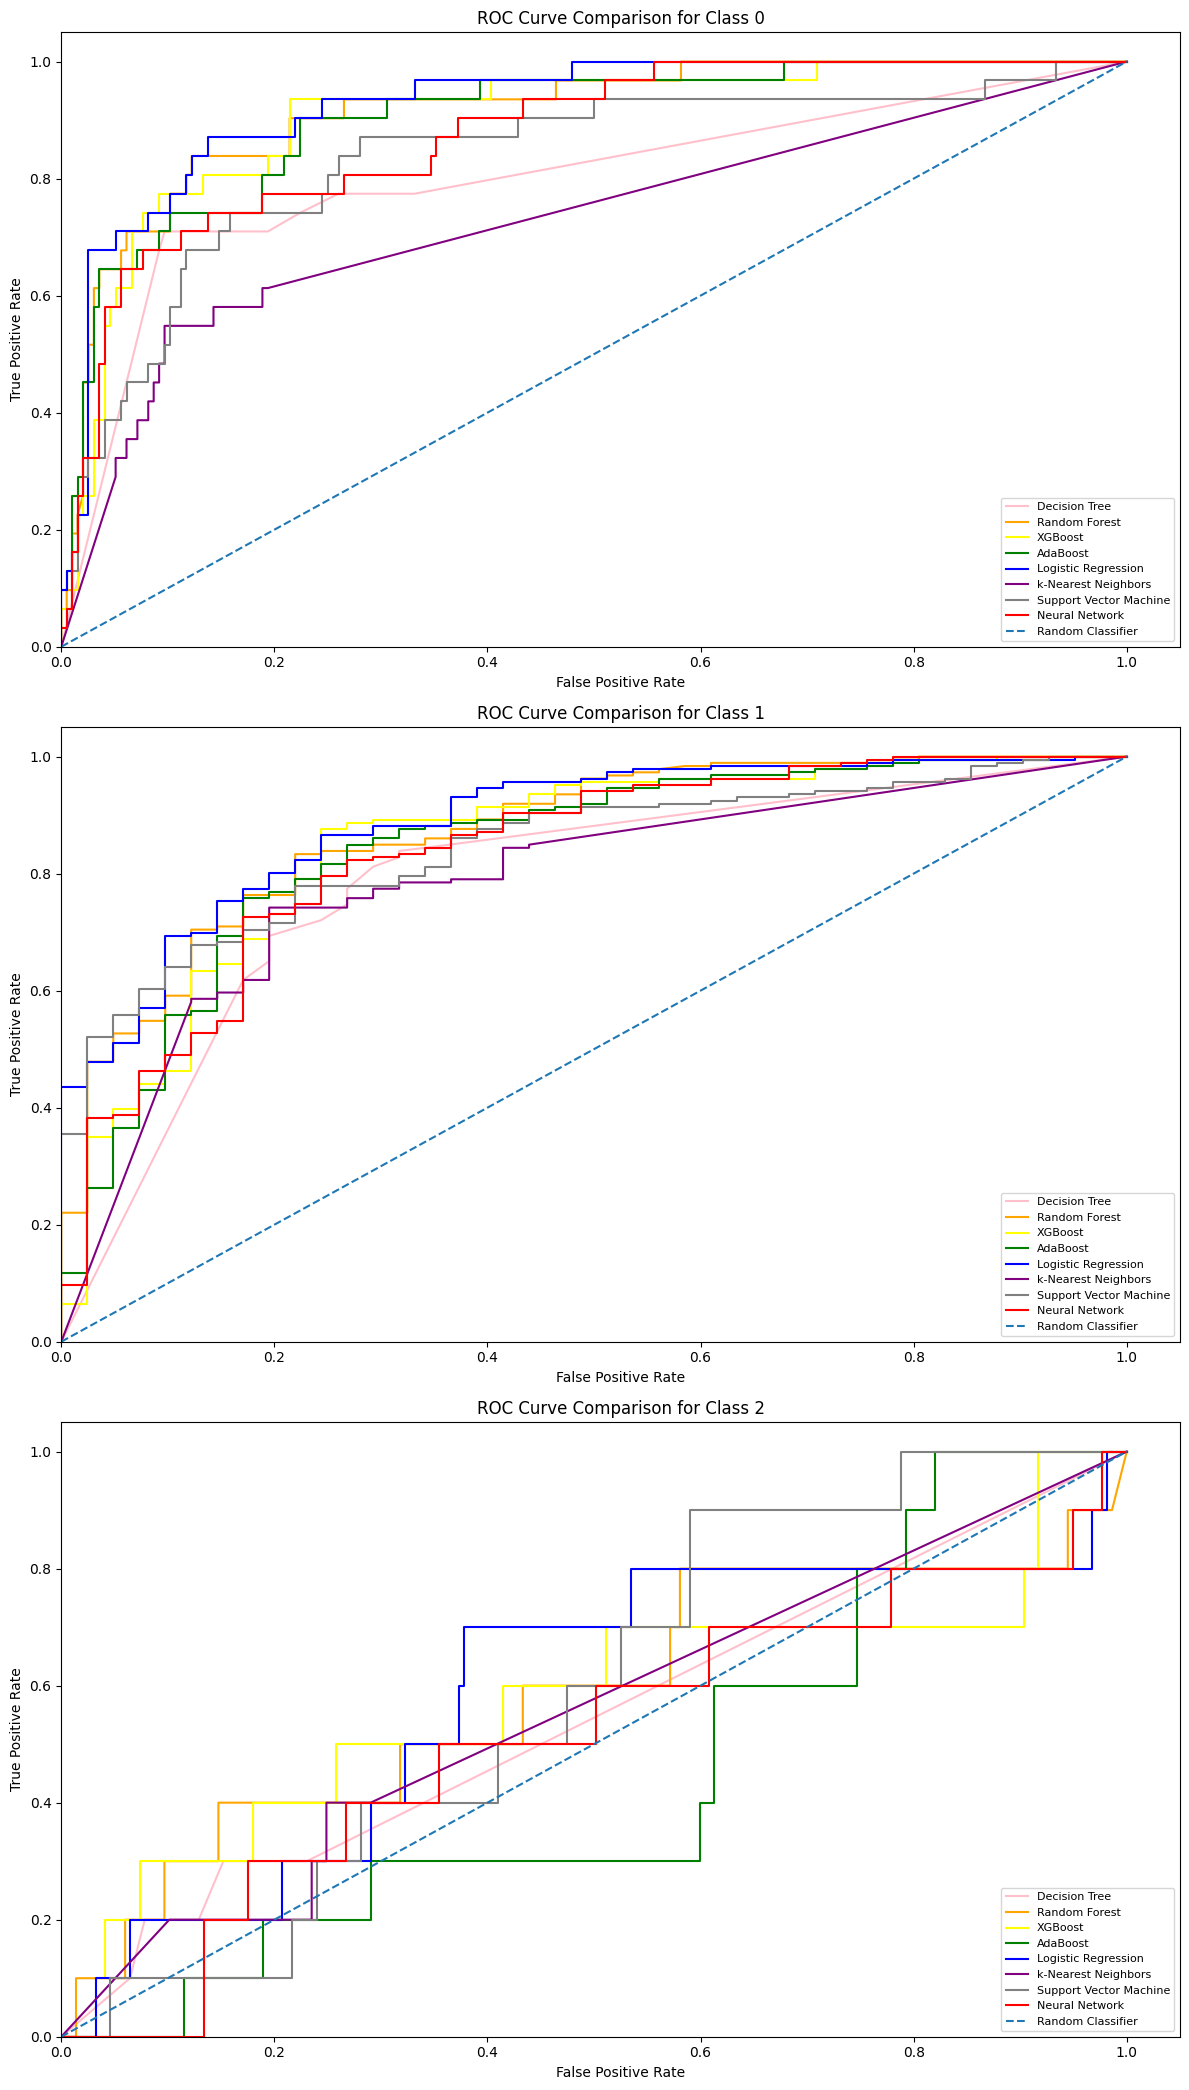

In [27]:
# Iterate through the models and compare the ROC AUC scores of the different classes using ROC plots
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

y_test_binarized = label_binarize(y_test, classes=[0,1,2])

fig, axes = plt.subplots(3, 1, figsize=(12,21))

colors = ["pink", "orange", "yellow", "green", "blue", "purple", "gray", "red"]

for class_idx in range(3):
    ax = axes[class_idx]
    for i, (model_name, y_pred_proba) in enumerate(pred_proba.items()):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, class_idx], y_pred_proba[:, class_idx])
        roc_auc = auc(fpr, tpr)
        
        ax.plot(fpr, tpr, color=colors[i], label=model_name)
    ax.plot([0,1], [0,1], ls="--", label="Random Classifier")
    ax.set_xlim([0,1.05])
    ax.set_ylim([0,1.05])
    ax.set_title(f"ROC Curve Comparison for Class {class_idx}")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()


## Differing importance of recall vs precision for the different classes

Recall : Out of all positive cases, how many of them were predicted positive?

Precision : Out of all predicted positive cases, how many of them were actually positive?

For the classes "Diabetes_yes" and "Diabetes_borderline",  it is more important to measure recall to ensure timely intervention and early treatment for Type 2 diabetes.

For the class "Diabetes_no", it is more important to measure precision to reduce the number of cases of shocking patients with misclassified results and having to undergo unnecessary treatment. However, due to the class imbalance towards "Diabetes_no", it is easy to achieve high precision by predicting "Diabetes_no" more often. Hence, F1 score, being the harmonic mean of precision and recall, is a good metric that shows if the models are achieving high precision at the expense of recall.

In [28]:
# Iterate through the models and compare the recall scores of "Diabetes_yes"
yes_recall_comparison = {}

for model_name, classification_report in classification_reports.items():
    
    yes_recall_comparison[model_name] = {
        "Recall" : classification_report["Diabetes_yes"]["recall"]
    }
    
    yes_recall_comparison_df = pd.DataFrame.from_dict(yes_recall_comparison, orient="index")
    
yes_recall_comparison_df = yes_recall_comparison_df.round(4).sort_values("Recall", ascending=False)

print(f"[Diabetes_yes] Recall comparison:\n{yes_recall_comparison_df}")

[Diabetes_yes] Recall comparison:
                        Recall
Random Forest           0.7742
XGBoost                 0.7419
AdaBoost                0.7419
Decision Tree           0.7097
Logistic Regression     0.7097
Neural Network          0.6774
k-Nearest Neighbors     0.5484
Support Vector Machine  0.5161


In [29]:
# Iterate through the models and compare the precision scores of "Diabetes_no"
no_precision_f1_comparison = {}

for model_name, classification_report in classification_reports.items():
    
    no_precision_f1_comparison[model_name] = {
        "Precision" : classification_report["Diabetes_no"]["precision"],
        "F1" : classification_report["Diabetes_no"]["f1-score"]
    }
    
    no_precision_comparison_df = pd.DataFrame.from_dict(no_precision_f1_comparison, orient="index")
    
no_precision_comparison_df = no_precision_comparison_df.round(4).sort_values("F1", ascending=False)

print(f"[Diabetes_no] Precision and F1 comparison:\n{no_precision_comparison_df}")

[Diabetes_no] Precision and F1 comparison:
                        Precision      F1
XGBoost                    0.9371  0.9086
AdaBoost                   0.9253  0.8944
Random Forest              0.9441  0.8761
Support Vector Machine     0.9130  0.8473
Neural Network             0.9351  0.8471
k-Nearest Neighbors        0.9388  0.8288
Logistic Regression        0.9549  0.7962
Decision Tree              0.9380  0.7683


In [30]:
# Iterate through the models and compare the recall scores of "Diabetes_borderline"
borderline_recall_comparison = {}

for model_name, classification_report in classification_reports.items():
    
    borderline_recall_comparison[model_name] = {
        "Recall" : classification_report["Diabetes_borderline"]["recall"]
    }
    
    borderline_recall_comparison_df = pd.DataFrame.from_dict(borderline_recall_comparison, orient="index")
    
borderline_recall_comparison_df = borderline_recall_comparison_df.round(4).sort_values("Recall", ascending=False)

print(f"[Diabetes_borderline] Recall comparison:\n{borderline_recall_comparison_df}")

[Diabetes_borderline] Recall comparison:
                        Recall
Decision Tree              0.3
Random Forest              0.3
Logistic Regression        0.3
XGBoost                    0.2
k-Nearest Neighbors        0.2
AdaBoost                   0.1
Support Vector Machine     0.1
Neural Network             0.1
